# Northeastern SMILE Lab - Recognizing Faces in the Wild
***Can you determine if two individuals are related?***


This notebook contains my implementation of a challenge hosted by [Kaggle](https://www.kaggle.com/c/recognizing-faces-in-the-wild). The data can be obtained from the link.

The idea is to recognize if two people are genetically related from photos of their faces.

Photos are provided in a folder structure like this:

> `-- Family F01` <br>
`---- Family Member F01M01`<br>
`------ Photos of Family Member F01M01`<br>
`---- Family Member F02M02`<br>
`------ Photos of Family Member F01M02`<br>
`-- Family F02`<br>
`---- Family Member F02M01`<br>
`------ Photos of Family Member F02M01`<br>
`---- Family Member F02M02`<br>
`------ Photos of Family Member F02M02`<br>
`(...)`

There are in total 2786 families, with varying number of members. Each member has also varying number of photos.

A datasheet is also provided giving two people paired and their relationship status (`0` for not genetically related, `1` for genetically related). It is important to remind that, within a family, not everyone is genetically related, such as husband and wife, and adopted children, for example. Also, natural children have only around half of the traits of their parents, and siblings only one-fourth.

I will explain my approach along the way.

## Importing dependencies

In [1]:
from collections import Counter
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import Sequence
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from PIL import Image
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import datetime
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import tensorflow as tf

Using TensorFlow backend.


## Creating a dataset structure

I will cycle through the folder structure within the set given for training to collect an ID for each family, family member and photo. This ID will be composed by the relative path to each folder/file.

In [2]:
df = pd.DataFrame(data = {'family': [], 'person': [], 'photos': []})
for family in glob.glob('train/*'):
    for person in glob.glob(family + '/*'):
        photos = tuple(glob.glob(person + '/*'))
        df = df.append(pd.Series({'family': family, 'person': person, 'photos': photos}), ignore_index = True)
df.head()

,family,person,photos
0,train\F0002,train\F0002\MID1,"(train\F0002\MID1\P00009_face3.jpg, train\F000..."
1,train\F0002,train\F0002\MID2,"(train\F0002\MID2\P00009_face2.jpg, train\F000..."
2,train\F0002,train\F0002\MID3,"(train\F0002\MID3\P00009_face1.jpg, train\F000..."
3,train\F0005,train\F0005\MID1,"(train\F0005\MID1\P00053_face1.jpg, train\F000..."
4,train\F0005,train\F0005\MID2,"(train\F0005\MID2\P00053_face2.jpg, train\F000..."


Now I will cycle within each family to generate all possible family member pairings. I will organize the pairings in a dataframe containing one column for each person in a pairing and an extra column with a tuple of both people, which will be useful later.

In [3]:
family = df.family.unique()
people = df.person.unique()
combinations = []
for fam in family:
    people_in_family = df[df.family == fam].person
    combinations =[*combinations, *list(itertools.combinations(people_in_family, 2))]
    p1 = [x[0] for x in combinations]
p2 = [x[1] for x in combinations]
combinations = pd.DataFrame({'p1': p1, 'p2': p2, 'tuples': [tuple(sorted([p1[i], p2[i]])) for i in range(len(combinations))]})
combinations.head()

,p1,p2,tuples
0,train\F0002\MID1,train\F0002\MID2,"(train\F0002\MID1, train\F0002\MID2)"
1,train\F0002\MID1,train\F0002\MID3,"(train\F0002\MID1, train\F0002\MID3)"
2,train\F0002\MID2,train\F0002\MID3,"(train\F0002\MID2, train\F0002\MID3)"
3,train\F0005\MID1,train\F0005\MID2,"(train\F0005\MID1, train\F0005\MID2)"
4,train\F0005\MID1,train\F0005\MID3,"(train\F0005\MID1, train\F0005\MID3)"


Now I will read the file containing kinship information.

In [4]:
ks = pd.read_csv('train_relationships.csv')
ks.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


Since I am running on Windows, I must convert `/` to `\\` in the paths given.

In [5]:
ks.p1 = ks.p1.apply(lambda x: 'train/' + x).apply(lambda x: str.replace(x, '/', '\\'))
ks.p2 = ks.p2.apply(lambda x: 'train/' + x).apply(lambda x: str.replace(x, '/', '\\'))

Now I will check if some pairings given in the kinship file do not contain photos.

In [6]:
len(ks) - ((ks.p1.isin(people)) & (ks.p2.isin(people))).sum()

231

231 pairings were absent from the photo database. They will be removed from the kinship dataframe. I will also include a column to this dataframe containing tuples of each pair of people, like I did for the whole photo database above.

In [7]:
ks = ks[(ks.p1.isin(people)) & (ks.p2.isin(people))]
ks['tuples'] = [tuple(sorted([ks.iloc[row, 0], ks.iloc[row, 1]])) for row in range(len(ks))]
ks.head()

,p1,p2,tuples
0,train\F0002\MID1,train\F0002\MID3,"(train\F0002\MID1, train\F0002\MID3)"
1,train\F0002\MID2,train\F0002\MID3,"(train\F0002\MID2, train\F0002\MID3)"
2,train\F0005\MID1,train\F0005\MID2,"(train\F0005\MID1, train\F0005\MID2)"
3,train\F0005\MID3,train\F0005\MID2,"(train\F0005\MID2, train\F0005\MID3)"
4,train\F0009\MID1,train\F0009\MID4,"(train\F0009\MID1, train\F0009\MID4)"


Now, by comparing the tuples present in both dataframes, I will include the kinship column to the first dataframe, filling with `0` for not genetically related and `1` for genetically related.

In [8]:
combinations['kinship'] = 0
combinations.loc[combinations['tuples'].isin(ks['tuples']), 'kinship'] = 1
combinations.head()

,p1,p2,tuples,kinship
0,train\F0002\MID1,train\F0002\MID2,"(train\F0002\MID1, train\F0002\MID2)",0
1,train\F0002\MID1,train\F0002\MID3,"(train\F0002\MID1, train\F0002\MID3)",1
2,train\F0002\MID2,train\F0002\MID3,"(train\F0002\MID2, train\F0002\MID3)",1
3,train\F0005\MID1,train\F0005\MID2,"(train\F0005\MID1, train\F0005\MID2)",1
4,train\F0005\MID1,train\F0005\MID3,"(train\F0005\MID1, train\F0005\MID3)",0


Now I would like to check if the proportion of related and unrelated pairings is balanced.

In [9]:
Counter(combinations['kinship'])

Counter({0: 2893, 1: 3367})

It is indeed quite balanced at this stage, with a slight prevalence of related pairs. Nevertheless, the next step is to generate pairings of individual photos, which will be ultimately compared. I will do this by cycling within each pair of people, and generating as many pairs of photos as there are photos available. Since it does not matter if I am comparing `photo1` with `photo2` or vice-versa, I will consider only the first possibility.

In [10]:
photo_combinations = pd.DataFrame({'tuples' : [], 'kinship' : []})
for row in range(len(combinations)):
    p1 = combinations.p1[row]
    p2 = combinations.p2[row]
    kinship_pair = [combinations.kinship[row]]
    
    photos1 = df[df.person == p1].photos
    photos1 = [list(x) for x in photos1][0]
    photos2 = df[df.person == p2].photos
    photos2 = [list(x) for x in photos2][0]
            
    photo_pairs = list(itertools.product(photos1, photos2))
    kinship_pairs = kinship_pair * len(photo_pairs)

    comb_temp = pd.DataFrame({'tuples' : photo_pairs, 'kinship' : kinship_pairs})
    photo_combinations = photo_combinations.append(comb_temp)
photo_combinations.kinship = pd.to_numeric(photo_combinations.kinship, downcast = 'integer')
photo_combinations.reset_index(drop = True, inplace = True)
photo_combinations.head()

,tuples,kinship
0,"(train\F0002\MID1\P00009_face3.jpg, train\F000...",0
1,"(train\F0002\MID1\P00009_face3.jpg, train\F000...",0
2,"(train\F0002\MID1\P00009_face3.jpg, train\F000...",0
3,"(train\F0002\MID1\P00009_face3.jpg, train\F000...",0
4,"(train\F0002\MID1\P00009_face3.jpg, train\F000...",0


We can now check how many photo combinations were generated.

In [11]:
len(photo_combinations)

433539

And also if this, which is my final dataset structure, is balanced.

In [12]:
Counter(photo_combinations['kinship'])

Counter({0: 268360, 1: 165179})

Now there are 100,000 more not related pairs. I will consider this when splitting this dataset into training, validation and test set.

## Visualizing photo pairs

So I will choose 10 random pairs from both related and not related people, and visualize them, to have an idea of what kind of information I am dealing with.

In [13]:
np.random.seed(24)
photo_combinations0 = photo_combinations[photo_combinations.kinship == 0]
photo_combinations0 = photo_combinations0.iloc[np.random.choice(range(len(photo_combinations0)), 10)].reset_index(drop = True)
photo_combinations1 = photo_combinations[photo_combinations.kinship == 1]
photo_combinations1 = photo_combinations1.iloc[np.random.choice(range(len(photo_combinations1)), 10)].reset_index(drop = True)

C:\Users\Denny\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


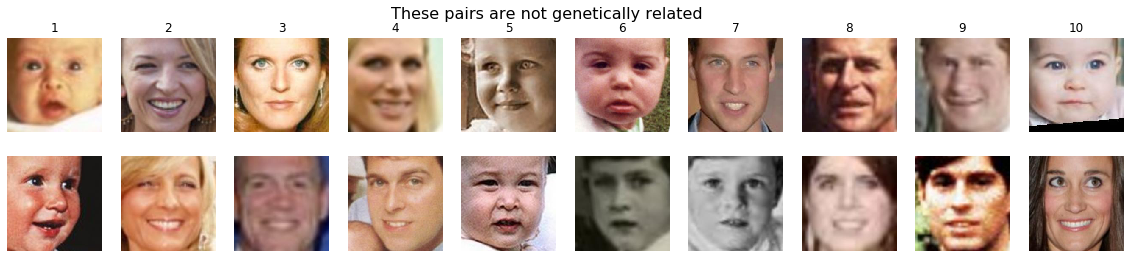

In [14]:
fig, ax = plt.subplots(2, 10, figsize = (20, 4))
fig.suptitle('These pairs are not genetically related', fontsize = 16)
for i in range(len(photo_combinations0)):
    with open(photo_combinations0.tuples[i][0],'rb') as f:
        img = Image.open(f)
        ax[0][i].imshow(img)
        ax[0][i].axis('off')
        ax[0][i].set_title(i+1)
    with open(photo_combinations0.tuples[i][1],'rb') as f:
        img = Image.open(f)
        ax[1][i].imshow(img)
        ax[1][i].axis('off')
fig.show()

C:\Users\Denny\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


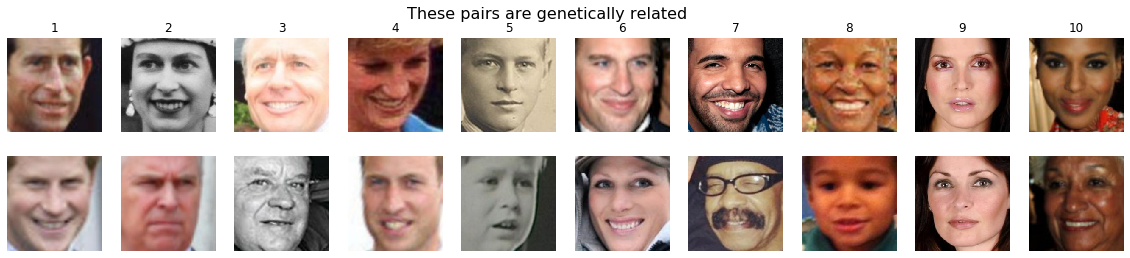

In [15]:
fig, ax = plt.subplots(2, 10, figsize = (20, 4))
fig.suptitle('These pairs are genetically related', fontsize = 16)
for i in range(len(photo_combinations1)):
    with open(photo_combinations1.tuples[i][0],'rb') as f:
        img = Image.open(f)
        ax[0][i].imshow(img)
        ax[0][i].axis('off')
        ax[0][i].set_title(i+1)
    with open(photo_combinations1.tuples[i][1],'rb') as f:
        img = Image.open(f)
        ax[1][i].imshow(img)
        ax[1][i].axis('off')
fig.show()

The characteristics of the photos are very diverse: some are colored, some are black and white; some are high resolution, some are low. They generally depict people frontally, but not always. Some people stare at the camera, others don't. Some wear glasses. But generally speaking, all of them seem to contain the relevant face features for comparison. 

## Final adjustments to the dataset

Now I will generate a training, a validation and a test set. But before this split, I will opt to sample from the original dataset, as it is too large and would take way too long to run. I am applying a sampling factor of 50, meaning that I will analyze further only 1/50 of the data.

In [16]:
X = photo_combinations.tuples.reset_index(drop = True)
y = photo_combinations.kinship.reset_index(drop = True)

In [17]:
SAMPLE_FACTOR = 50
if SAMPLE_FACTOR > 1:
    X, _, y, _ = train_test_split(X, y, test_size = 1-1/SAMPLE_FACTOR, random_state = 1, stratify = y)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.10, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.20, random_state = 1, stratify = y_train_val)

In [18]:
train_data = pd.DataFrame([X_train, y_train]).T
val_data = pd.DataFrame([X_val, y_val]).T
test_data = pd.DataFrame([X_test, y_test]).T

## Setting up the model

It is time decide what to do with the data!

Well, first of all, we are analyzing faces. This is good news, because there are many trained models already available for analyzing faces. I decided to go with the [VGGFace](http://www.robots.ox.ac.uk/~vgg/software/vgg_face/) workflow, which is an open source convolutional model trained exhaustively on publicly available face datasets. I will use the [VGG Face implementation in Keras](https://github.com/rcmalli/keras-vggface), with the feature extraction part of the RESNET50 model. Note: if not previously installed, it must be done according to the description in this last link.

My implementation will make us of a siamese network, using blocks of both the VGGFace model and a dense network model of my own design. The idea is to pass each of the two photos I will be comparing to the RESNET50 model (henceforth referred as *base model*) to convert them to a feature map of length of 1,024. Then, the feature maps of both photos are compared, by calculating their absolute difference. Why absolute? Well, first, as previously mentioned, it does not matter if I am comparing `photo 1` to `photo 2` or vice-versa. Second, I am not interested in the direction of any point difference (say, comparing noses turns up a negative value but comparing eyes turns a positive one), only in its magnitude (meaning, I want to know how different noses and eyes are). After this difference has been calculated, I will feed the resulting 1,024-long vector to a dense network, to be trained in reference to the provided labels, `1` for related and `0` for not-related. The last layer contains a sigmoid activation function because the challenge asks the model to return a probability of kinship. The weights and biases in this last part of the architecture will be responsible for assigning kinship to new photo pairs.

### Function to initiate the model

In [19]:
def my_model():
    random.seed(1)
    base_model = VGGFace(model = 'resnet50', include_top = False, input_shape = (224, 224, 3), pooling = 'avg')
    
    for x in base_model.layers:
        x.trainable = False

    input_1 = Input(shape = (224, 224, 3))
    input_2 = Input(shape = (224, 224, 3))

    x1 = base_model(input_1)
    x2 = base_model(input_2)
    
    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))
    
    x = L1_layer([x1, x2])
    
    class1 = Dense(1024, activation = 'relu')(x)
    class1 = Dropout(0.20)(class1)
    class2 = Dense(256, activation = 'relu')(class1)
    class2 = Dropout(0.20)(class2)
    out = Dense(1, activation = 'sigmoid')(class2)

    model = Model([input_1, input_2], out)
    
    model.compile(loss = 'binary_crossentropy', metrics = ['mse', 'acc', auroc], optimizer = Adam(0.00001))
    
    model.summary()
    
    return model

Since the challenge is evaluated by the AUC metric, I am opting to calculate it while training. This metric is not available in the Keras library though. Therefore, I am creating an `auroc` function to calculate AUC using the function from the Scikit-Learn library.

### AUC metric calculation

In [20]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

Now I need to implement a generator, to spit out memory-fit batches of training (or validation/prediction) instances. I will create a generator class, inheriting from the Sequence class from Keras. This generator will receive the training/validation/testing data (containing the paths for the photos pairs and the kinship label), the desired batch size, and an indicator in case it will be used for validation or prediction (in which cases the label provided will be ignored). Then it will use the photo paths to load the images, preprocess them (according to the [Keras implementation of VGG Face documentation](https://github.com/rcmalli/keras-vggface#prediction)) and yield the images in the correct format to pass to the model, as well as the label when training.

### Preprocessing function

In [21]:
def pre_proc(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = utils.preprocess_input(img, version = 2)
    return img

### Generator class definition

In [22]:
class generator(Sequence):

    def __init__(self, data, batch_size, validation = False, prediction = False):
        self.x = data.tuples
        self.x0 = [x[0] for x in self.x]
        self.x1 = [x[1] for x in self.x]
        self.y = data.kinship
        self.batch_size = batch_size
        self.len = self.__len__()
        self.validation = validation
        self.prediction = prediction

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        if self.validation or self.prediction:
            print('Validation/prediction batch {} of {}'.format(idx+1, self.len), end = '\r')
        batch0 = self.x0[idx*self.batch_size:(idx+1)*self.batch_size]
        batch0 = np.array([pre_proc(x) for x in batch0]).squeeze(1)
        batch1 = self.x1[idx*self.batch_size:(idx+1)*self.batch_size]
        batch1 = np.array([pre_proc(x) for x in batch1]).squeeze(1)
        kinship_batch = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        kinship_batch = np.array([np.array(target, ndmin = 1) for target in kinship_batch])
        if not self.prediction:
            return ([batch0, batch1], kinship_batch)
        else:
            return([batch0, batch1])

## Training the model

We are finally here! Let me first define some global variables...

In [23]:
BS = 50 # batch size
EPOCHS = 50 # number of epochs

... and initiate the model and the training/validation generators.

In [24]:
model = my_model()
gen = generator(train_data, BS)
gen_val = generator(val_data, BS, validation = True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________

Now I will set a callback list containing a checkpoint saver. This saver will monitor the AUC metric in the validation set.

In [25]:
checkpoint = ModelCheckpoint('checkpoint_faces.h5', monitor = 'val_auroc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

Time for training! Since this takes a long time to run, I will save start/end times to document an estimate of how long I waited.

In [26]:
start = datetime.datetime.now()
history = model.fit_generator(gen, epochs = EPOCHS, validation_data = gen_val, callbacks = callbacks_list, verbose = 1, shuffle = True)
end = datetime.datetime.now()

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Epoch 00001: val_auroc improved from -inf to 0.68433, saving model to checkpoint_faces.h5.3041 - acc: 0.5784 - auroc: 0.5600Validation/prediction batch 1 of 32
125/125 [==============================] - 643s 5s/step - loss: 0.9725 - mean_squared_error: 0.3042 - acc: 0.5784 - auroc: 0.5602 - val_loss: 0.6921 - val_mean_squared_error: 0.2318 - val_acc: 0.6624 - val_auroc: 0.6843
Epoch 2/50
Epoch 00002: val_auroc improved from 0.68433 to 0.73734, saving model to checkpoint_faces.h558 - acc: 0.6315 - auroc: 0.6496Validation/prediction batch 1 of 32
125/125 [==============================] - 695s 6s/step - loss: 0.7781 - mean_squared_error: 0.2557 - acc: 0.6313 - auroc: 0.6498 - val_loss: 0.6087 - val_mean_squared_error: 0.2058 - val_acc: 0.6867 - val_auroc: 0.7373
Epoch 3/50
Epoch 00003: val_auroc improved from 0.73734 to 0.76590, saving model to checkpoint_faces.h537 - acc: 0.6715 - auroc: 0.7074Validation/prediction batch 1 of 32

Epoch 00021: val_auroc improved from 0.87242 to 0.87421, saving model to checkpoint_faces.h527 - acc: 0.8711 - auroc: 0.9456Validation/prediction batch 1 of 32
125/125 [==============================] - 650s 5s/step - loss: 0.3031 - mean_squared_error: 0.0929 - acc: 0.8707 - auroc: 0.9453 - val_loss: 0.4402 - val_mean_squared_error: 0.1433 - val_acc: 0.7976 - val_auroc: 0.8742
Epoch 22/50
Epoch 00022: val_auroc improved from 0.87421 to 0.87527, saving model to checkpoint_faces.h574 - acc: 0.8813 - auroc: 0.9517Validation/prediction batch 1 of 32
125/125 [==============================] - 682s 5s/step - loss: 0.2879 - mean_squared_error: 0.0873 - acc: 0.8813 - auroc: 0.9517 - val_loss: 0.4330 - val_mean_squared_error: 0.1400 - val_acc: 0.7988 - val_auroc: 0.8753
Epoch 23/50
Epoch 00023: val_auroc improved from 0.87527 to 0.87740, saving model to checkpoint_faces.h502 - acc: 0.8957 - auroc: 0.9584Validation/prediction batch 1 of 32
125/125 [==============================] - 707s 6s/step 

Epoch 42/50
Epoch 00042: val_auroc improved from 0.90076 to 0.90110, saving model to checkpoint_faces.h570 - acc: 0.9711 - auroc: 0.9962Validation/prediction batch 1 of 32
125/125 [==============================] - 590s 5s/step - loss: 0.1092 - mean_squared_error: 0.0270 - acc: 0.9713 - auroc: 0.9962 - val_loss: 0.4165 - val_mean_squared_error: 0.1263 - val_acc: 0.8270 - val_auroc: 0.9011
Epoch 43/50
Epoch 00043: val_auroc improved from 0.90110 to 0.90141, saving model to checkpoint_faces.h559 - acc: 0.9724 - auroc: 0.9970Validation/prediction batch 1 of 32
125/125 [==============================] - 585s 5s/step - loss: 0.1064 - mean_squared_error: 0.0260 - acc: 0.9725 - auroc: 0.9970 - val_loss: 0.4233 - val_mean_squared_error: 0.1285 - val_acc: 0.8225 - val_auroc: 0.9014
Epoch 44/50
Epoch 00044: val_auroc improved from 0.90141 to 0.90220, saving model to checkpoint_faces.h545 - acc: 0.9742 - auroc: 0.9974Validation/prediction batch 1 of 32
125/125 [==============================] - 5

How long did it take?

In [27]:
print('Training lasted: ' + str(end - start))

Training lasted: 8:28:52.334977


## Evaluating the trained model

First let us check the evolution of the evaluation metrics.

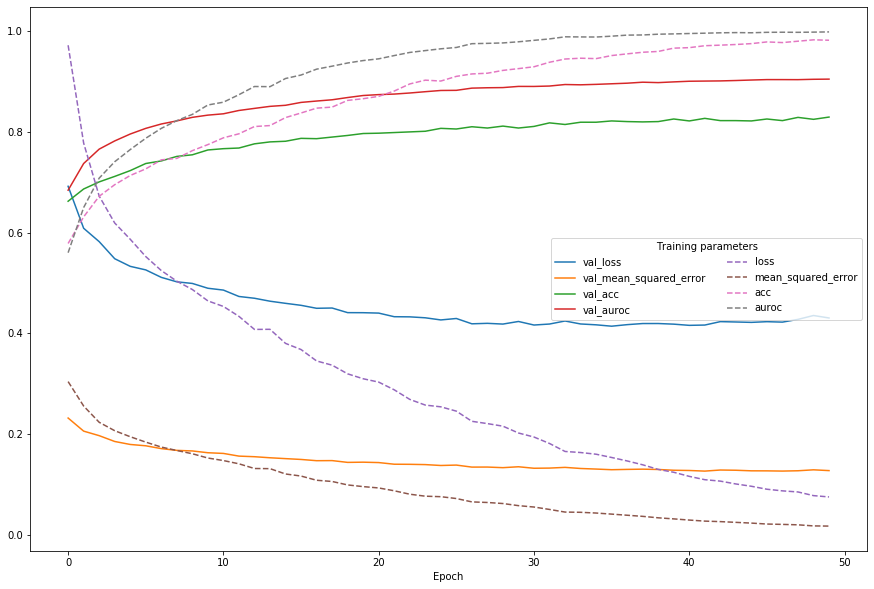

In [28]:
plt.figure(figsize = (15, 10))
for elem in history.history:
    if 'val' in elem:
        plt.plot(history.history[elem])
    else:
        plt.plot(history.history[elem], '--')
plt.xlabel('Epoch')
plt.legend(history.history.keys(), title = 'Training parameters', ncol = 2)

In general we observe the regular behavior for deep learning algorithms: the metrics for the training set are better than those for the validation set, and all metrics get better with more epochs. AUC stabilized around 0.99 for the training set and 0.90 for the validation set.

## Testing the model

Let us load back the best iteration of the model...

In [29]:
model = load_model('checkpoint_faces.h5', custom_objects = {'auroc' : auroc})

... then use it to predict kinship on the test set.

In [30]:
gen_test = generator(test_data, BS, prediction = True)
y_pred = model.predict_generator(gen_test)

I would like to check accuracy and AUC according to the test set.

In [31]:
print('Accuracy : {:.2%}'.format(accuracy_score([int(x) for x in test_data.kinship], [np.round(x) for x in y_pred])))
print('AUC : {:.2%}'.format(roc_auc_score([int(x) for x in test_data.kinship], y_pred)))

Accuracy : 82.58%
AUC : 90.57%


We can now visually inspect the ROC. I am plotting the regular False Positive Rate and True Positive Rate on the x and y axes, but also the Thresholds aligned to the right-y axis.

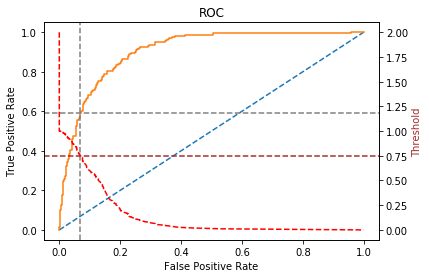

In [32]:
fpr, tpr, thresholds = roc_curve([int(x) for x in test_data.kinship], y_pred)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle = '--')
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC')

thresh = 0.75

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='brown')
ax2.axhline(thresh, linestyle = '--', color = 'brown')

delta_thresh = abs(thresholds - thresh)
pos = np.argmin(delta_thresh)

ax.axvline(fpr[pos], linestyle = '--', color = 'grey')
ax.axhline(tpr[pos], linestyle = '--', color = 'grey')

From a preliminary visual inspection of the plot, I chose the threshold 0.75 as a cut-off, which is where the false positive rate changes seem to get larger than the true positive rate changes. The brown dotted line indicates the chosen threshold of 0.75; at this threshold, the true positive rate is around 0.6 and the false positive rate is around 0.07.

In [33]:
print('TPR : {}'.format(tpr[pos]))
print('FPR : {}'.format(fpr[pos]))

TPR : 0.593939393939394
FPR : 0.06890130353817504


Now, as a last visualization I like to look at, I will plot a random sample of 100 values of the true labels along with their predicted kinship probability. The threshold of 0.75 will be highlighted. Blue dots mean those instances of the test set where the label agrees with the model prediction; red dots mean otherwise.

In [34]:
random.seed(24)
idx_sample = random.sample(range(len(y_pred)), len(y_pred))
true_values = test_data.kinship.iloc[idx_sample[:100]].values
pred_values = y_pred[idx_sample[:100]].squeeze(1)
pred_rounded = [1 if x > thresh else 0 for x in pred_values]
correct_predictions = true_values == pred_rounded

Text(0, 0.5, '')

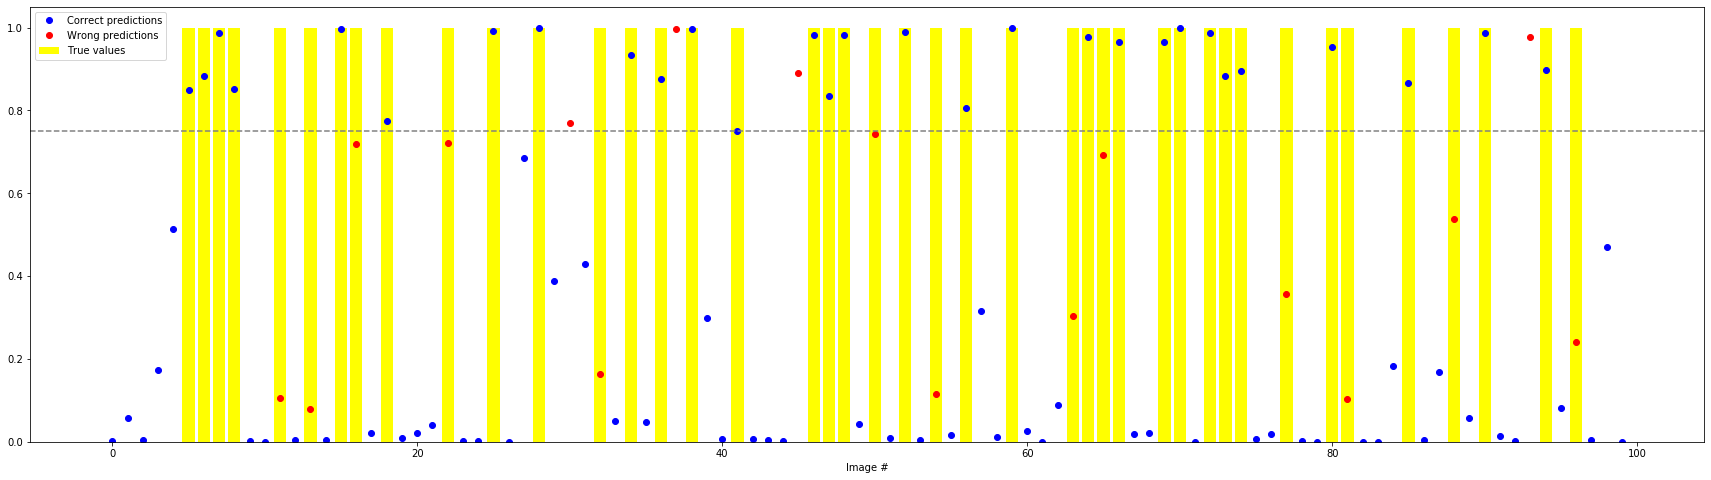

In [35]:
plt.figure(figsize = (30, 8))
plt.bar(height = true_values, x = range(100), color = 'yellow', label = 'True values')
plt.plot(np.array(range(100))[correct_predictions], pred_values[correct_predictions], 'o', color = 'blue', label = 'Correct predictions')
plt.plot(np.array(range(100))[~correct_predictions], pred_values[~correct_predictions], 'o', color = 'red', label = 'Wrong predictions')
plt.axhline(thresh, linestyle = '--', color = 'grey')
plt.legend()
plt.xlabel('Image #')
plt.ylabel('')

This is a nice visualization of how the model is doing, and it does seem good. Given the threshold of 0.75, we can calculate the accuracy in the test set.

In [36]:
true_values = test_data.kinship.values
pred_values = y_pred.squeeze(1)
pred_rounded = [1 if x > thresh else 0 for x in pred_values]
correct_predictions = true_values == pred_rounded
print('Accuracy : {:.2%}'.format(sum(correct_predictions)/len(pred_values)))

Accuracy : 80.05%


Though the results with the test set might be considered good, an obvious suggestion for improvement is to train more instances. As a fact, I have trained the whole dataset along 10 epochs in parallel, but each epoch took around 10 hours to complete. The validation AUC got up to 0.9963 though. Depending on the application, such an improvement is clearly worthwhile.

And that is that! [Arh-wooooooooo!](https://www.urbandictionary.com/define.php?term=Howl)